In [23]:
# Setup and imports
import sys
import os

# Add project root to path (handles both Docker /work and local environments)
if os.path.exists('/work'):
    sys.path.insert(0, '/work')  # Docker environment
else:
    sys.path.insert(0, os.path.abspath('..'))  # Local environment

# ====================================================================================
# ===============================================                                   ==
# Libraries for dataset verification with DVC. ==                                   ==
# ===============================================                                   ==
from pathlib import Path  # Cross-platform path handling                            ==
from typing import Dict, Tuple, Optional  # Optional type hints for better clarity  ==
import os  # File system and environment variable handling                          ==
import yaml  # Read .dvc (YAML) pointer files                                       ==
import hashlib  # Compute MD5 hashes to verify data integrity                       ==
import subprocess    # Execute SO commands                                          ==
# ====================================================================================

#import de librerias para EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import numpy as np

#importa libraies for data drifting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.mixture import GaussianMixture
# from alibi_detect.cd import KSDrift # Disabled due to incompatibility with the current functional docker
from scipy.stats import ks_2samp


# Import our custom modules
from src import config
from src.data_utils import load_data
from src.plots import (
    plot_target_distribution,
    plot_correlation_matrix,
    create_eda_summary_dashboard,
    plot_categorical_analysis,
    plot_numerical_relationship
)

# Import Phase 1 feature engine (from features.py file, not features/ directory)
import importlib
features_module = importlib.import_module('src.features_engine')
AbsenteeismFeatureEngine = features_module.AbsenteeismFeatureEngine

In [2]:
# ===============================================================
# DVC dataset verification helpers (MD5 check + pull fallback) ==
# ===============================================================

def ensure_repo_ready(repo_root: str = "/work") -> None:
    """
    Verifies that:
    - `repo_root` is a valid project folder with Git and DVC.
    - Directory `repo_root` exists.
    - It contains a `.git` subdirectory (it's a Git repo).
    - It contains a `.dvc` subdirectory (it's a DVC repo).

    Raises:
    - FileNotFoundError if `repo_root` does not exist.
    - RuntimeError if `.git` or `.dvc` is missing.
    """
    if not os.path.isdir(repo_root):
        raise FileNotFoundError(f"Repo root does not exist: {repo_root}")
    if not os.path.isdir(os.path.join(repo_root, ".git")):
        raise RuntimeError(f"Not a Git repo: {repo_root}")
    if not os.path.isdir(os.path.join(repo_root, ".dvc")):
        raise RuntimeError(f"Not a DVC repo: {repo_root} (.dvc not found)")


def _md5_file(path: str, chunk_size: int = 1024 * 1024) -> str:
    """
    Computes the MD5 hash of a file by streaming it from disk to verify integrity
    against the value stored by DVC in the `.dvc` pointer (default md5-based cache).

    Parameters:
    - path: absolute file path.
    - chunk_size: read block size in bytes (default 1 MB).

    Returns:
    - Hex MD5 string of the file content.
    """
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()


def _read_expected_md5_from_dvc(pointer_path: str) -> Optional[str]:
    """
    Reads the expected MD5 from a single-file `.dvc` pointer.

    `.dvc` format:
      - md5: <hash>
      - hash: md5
      - path: <file_name>

    Parameters:
    - pointer_path: absolute path to the `.dvc` file.

    Returns:
    - The MD5 string if present, or None if the pointer does not exist / lacks md5.

    Use:
    - Compare the expected MD5 from `.dvc` with the actual local file MD5.
    """
    if not os.path.exists(pointer_path):
        return None
    with open(pointer_path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f) or {}
    outs = data.get("outs") or []
    if not outs:
        return None
    out = outs[0]
    return out.get("md5") or out.get("checksum") or None


def _dvc_pull_target(path_repo_rel: str, repo_root: str = "/work") -> None:
    """
    Runs `dvc pull <path>` or `<path>.dvc` to materialize the correct version from the remote (S3)
    into the local workspace/cache. Raises if it fails (credentials, permissions, etc.).

    Parameters:
    - path_repo_rel: repo-relative path to fetch (e.g., "data/raw/file.csv").
    - repo_root: repo root (e.g., "/work").
    """
# Build possible targets
    dvc_pointer = os.path.join(repo_root, path_repo_rel + ".dvc")
    if os.path.exists(dvc_pointer):
        target = path_repo_rel + ".dvc"
    else:
        target = path_repo_rel

    # Try pulling
    result = subprocess.run(
        ["dvc", "pull", "--quiet", target],
        cwd=repo_root,
        capture_output=True,
        text=True,
    )

    # Raise if failed
    if result.returncode != 0:
        raise RuntimeError(
            f"Failed to run 'dvc pull {target}':\n"
            f"STDOUT:\n{result.stdout}\nSTDERR:\n{result.stderr}"
        )



def dvc_read_csv_verified(
    path_repo_rel: str,
    repo_root: str = "/work",
    prefer_dvc: bool = False,
    verify_local_md5: bool = True,
    pandas_read_csv_kwargs: Optional[Dict] = None,
) -> Tuple[pd.DataFrame, str]:
    """
    Read a DVC-versioned CSV ensuring integrity when reading locally.

    Strategy:
    - If `prefer_dvc=True`: force fetching the official version with `dvc pull`
      and then read locally. Returns ("pulled").
    - If `prefer_dvc=False`:
        1) If the local file exists and `verify_local_md5=True`, compare local MD5
           with the expected MD5 from the `.dvc` pointer.
           * If equal -> read local (fast). Returns ("local").
           * If NOT equal -> run `dvc pull` and read the official version. Returns ("pulled").
        2) If the file does NOT exist -> run `dvc pull` and read the official version. Returns ("pulled").

    Parameters:
    - path_repo_rel: repo-relative CSV path (e.g., "data/raw/file.csv").
    - repo_root: repo root (e.g., "/work").
    - prefer_dvc: if True, ignore local state and fetch official version with `dvc pull`.
    - verify_local_md5: if True, validate local MD5 before trusting local read.
    - pandas_read_csv_kwargs: kwargs for `pandas.read_csv()` (sep, encoding, etc.).

    Returns:
    - (df, source) where source ∈ {"local", "pulled"} describing the read source.

    Exceptions:
    - Raises if the file cannot be materialized from the remote (credentials,
      permissions, or missing blob).
    """
    ensure_repo_ready(repo_root)
    if pandas_read_csv_kwargs is None:
        pandas_read_csv_kwargs = {}

    local_path = os.path.join(repo_root, path_repo_rel)
    dvc_pointer = local_path + ".dvc"  # e.g., data/raw/file.csv.dvc
    expected_md5 = _read_expected_md5_from_dvc(dvc_pointer)

    # Option: force “official” read by fetching from S3
    if prefer_dvc:
        _dvc_pull_target(path_repo_rel, repo_root)
        # Note: when forcing, we don’t compare MD5; we assume `dvc pull` fetched the official version.
        return pd.read_csv(local_path, **pandas_read_csv_kwargs), "pulled"

    # If a local file exists, decide based on MD5
    if os.path.exists(local_path):
        if verify_local_md5 and expected_md5:
            try:
                md5_local = _md5_file(local_path)
                if md5_local == expected_md5:
                    # Note: “MD5 OK: local matches .dvc”
                    # Use the local version (faster) because it’s identical to the “official” one.
                    return pd.read_csv(local_path, **pandas_read_csv_kwargs), "local"
                else:
                    # MD5 differs: local != .dvc → run dvc pull
                    _dvc_pull_target(path_repo_rel, repo_root)
                    return pd.read_csv(local_path, **pandas_read_csv_kwargs), "pulled"
            except Exception:
                # Any issue during the check → ensure consistency with a pull
                _dvc_pull_target(path_repo_rel, repo_root)
                return pd.read_csv(local_path, **pandas_read_csv_kwargs), "pulled"
        else:
            # Local read without MD5 verification
            return pd.read_csv(local_path, **pandas_read_csv_kwargs), "local"

    # If no local file, fetch the official version
    _dvc_pull_target(path_repo_rel, repo_root)
    return pd.read_csv(local_path, **pandas_read_csv_kwargs), "pulled"


In [3]:
# =======================================
# Configurable dataset read parameters ==
# =======================================

# Docker mounts the project at /work. If your compose changes, adjust REPO_ROOT accordingly.
REPO_ROOT = "/work"  # Where the repo is mounted.
PATH = "data/raw/work_absenteeism_modified.csv"  # Repo-relative path of the DVC-versioned dataset.

# Arguments forwarded to pandas.read_csv. Optional: delimiter, encoding, etc.
READ_KW: Dict = {}  # e.g.: {"sep": ",", "encoding": "utf-8"}

# Read mode:
# - PREFER_DVC=True  -> Force fetching the official version with `dvc pull` and read it.
# - PREFER_DVC=False -> Prefer local only if (and only if) MD5 matches the one in the .dvc.
PREFER_DVC = False
VERIFY_LOCAL_MD5 = True

# =====================================================
# Environment inspection + demo read with MD5 legend ==
# =====================================================
print("Repo root:", REPO_ROOT, "| exists:", Path(REPO_ROOT).exists())
print("Expected CSV:", PATH)

# Show expected MD5 (if the pointer exists)
pointer_path = os.path.join(REPO_ROOT, PATH) + ".dvc"
expected = _read_expected_md5_from_dvc(pointer_path)
print("Expected MD5 (.dvc):", expected or "<no md5 in pointer>")

# If a local file exists, compute local MD5 and compare
local_abs = os.path.join(REPO_ROOT, PATH)
if os.path.exists(local_abs) and expected:
    try:
        local_md5 = _md5_file(local_abs)
        print("Local MD5:", local_md5)
        print("MD5 matches .dvc?", "YES ✅" if local_md5 == expected else "NO ❌")
    except Exception as e:
        print("Could not compute local MD5:", type(e).__name__, str(e)[:120])

# --- Robust read with integrity verification ---
# dvc_read_csv_verified does:
#   1) If PREFER_DVC=True -> run `dvc pull` and read the official version (“pulled”).
#   2) If PREFER_DVC=False:
#        - If the local file exists and VERIFY_LOCAL_MD5=True:
#            compare local MD5 against the MD5 from the .dvc pointer.
#            * If equal -> read local (fast) and consistent.
#            * If different -> `dvc pull` and read the official version.
#        - If the file does not exist locally -> `dvc pull` and read the official version.
df, source = dvc_read_csv_verified(
    PATH,
    repo_root=REPO_ROOT,
    prefer_dvc=PREFER_DVC,
    verify_local_md5=VERIFY_LOCAL_MD5,
    pandas_read_csv_kwargs=READ_KW,
)

print(f"Read from: {source} | rows={len(df)} | cols={len(df.columns)}")


Repo root: /work | exists: True
Expected CSV: data/raw/work_absenteeism_modified.csv
Expected MD5 (.dvc): 96c318341d1846f567be7127f52d03e1
Local MD5: 96c318341d1846f567be7127f52d03e1
MD5 matches .dvc? YES ✅
Read from: local | rows=754 | cols=22


In [4]:
absenteeism_df = df


**1. Identificar porcentaje de valores faltantes para tomar decisiones de limpieza de datos**

In [5]:
def detectar_valores_invalidos(df):
    """
    Detecta valores faltantes disfrazados y posibles datos inválidos por columna.
    """
    print("Resumen de valores a limpiar:")
    for col in df.columns:
        question_marks = (df[col] == '?').sum()
        errors = (df[col] == 'error').sum()
        unknowns = (df[col] == 'unknown').sum()
        invalid = (df[col] == 'invalid').sum()
        bad = (df[col] == 'bad').sum()
        nan_strings = (df[col].astype(str).str.strip().str.lower() == 'nan').sum()

        # Solo mostrar si hay algo que limpiar
        if any([question_marks, errors, unknowns, invalid, bad, nan_strings]):
            print(f"{col}:")
            if question_marks > 0:
                print(f"  '?' : {question_marks} ({question_marks/len(df)*100:.1f}%)")
            if errors > 0:
                print(f"  'error' : {errors} ({errors/len(df)*100:.1f}%)")
            if invalid > 0:
                print(f"  'invalid' : {invalid} ({invalid/len(df)*100:.1f}%)")
            if unknowns > 0:
                print(f"  'unknown' : {unknowns} ({unknowns/len(df)*100:.1f}%)")
            if bad > 0:
                print(f"  'bad' : {bad} ({bad/len(df)*100:.1f}%)")
            if nan_strings > 0:
                print(f"  'NAN' strings : {nan_strings} ({nan_strings/len(df)*100:.1f}%)")

# Usar la función
detectar_valores_invalidos(absenteeism_df)

Resumen de valores a limpiar:
ID:
  '?' : 1 (0.1%)
  'invalid' : 1 (0.1%)
  'NAN' strings : 8 (1.1%)
Reason for absence:
  '?' : 1 (0.1%)
  'error' : 2 (0.3%)
  'NAN' strings : 8 (1.1%)
Month of absence:
  'error' : 2 (0.3%)
  'NAN' strings : 12 (1.6%)
Day of the week:
  'invalid' : 1 (0.1%)
  'NAN' strings : 9 (1.2%)
Seasons:
  'NAN' strings : 5 (0.7%)
Transportation expense:
  '?' : 2 (0.3%)
  'invalid' : 2 (0.3%)
  'NAN' strings : 10 (1.3%)
Distance from Residence to Work:
  '?' : 2 (0.3%)
  'NAN' strings : 13 (1.7%)
Service time:
  '?' : 1 (0.1%)
  'NAN' strings : 8 (1.1%)
Age:
  '?' : 1 (0.1%)
  'invalid' : 1 (0.1%)
  'NAN' strings : 5 (0.7%)
Work load Average/day:
  '?' : 1 (0.1%)
  'error' : 1 (0.1%)
  'NAN' strings : 15 (2.0%)
Hit target:
  '?' : 2 (0.3%)
  'invalid' : 1 (0.1%)
  'NAN' strings : 8 (1.1%)
Disciplinary failure:
  'error' : 2 (0.3%)
  'invalid' : 1 (0.1%)
  'NAN' strings : 7 (0.9%)
Education:
  'NAN' strings : 9 (1.2%)
Son:
  '?' : 1 (0.1%)
  'error' : 2 (0.3%)
  

**2. Limpieza**

In [6]:
# Initialize feature engine
engine = AbsenteeismFeatureEngine()

print("Step 1: Data Cleaning")
df_clean = engine.clean_data(absenteeism_df)
print(f"  Original: {len(absenteeism_df)} rows")
print(f"  Cleaned: {len(df_clean)} rows")
print(f"  Removed: {len(absenteeism_df) - len(df_clean)} rows ({(len(df)-len(df_clean))/len(df)*100:.1f}%)")

2025-11-17 03:55:14,726 - src.features_engine - INFO - Starting data cleaning...
2025-11-17 03:55:14,737 - src.features_engine - INFO - Removed 23 outliers (>120 hours)
2025-11-17 03:55:14,739 - src.features_engine - INFO - Data cleaning complete. Final shape: (713, 22)


Step 1: Data Cleaning
  Original: 754 rows
  Cleaned: 713 rows
  Removed: 41 rows (5.4%)


**2.1 Eliminar filas con ID faltantes**
- Sin ID válido no se puede relacionar la información.

In [7]:
# 1. Eliminar filas con ID faltante
absenteeism_df['ID'] = absenteeism_df['ID'].replace('?', np.nan)
absenteeism_df['ID'] = absenteeism_df['ID'].replace('invalid', np.nan)
df_clean= absenteeism_df.dropna(subset=['ID'])

**2.2 Se elimina columna completa: mixed_type_col por falta de información**

In [8]:
df_clean = df_clean.drop('mixed_type_col', axis=1)

**2.3 Limpieza de caracteres extraños en dataframe y se susutituyen por NAN**

In [9]:
# Lista de valores a limpiar
valores_invalidos = ['?', 'error', 'invalid', 'unknown', 'bad']
valores_nan_str = ['NAN', 'nan', 'NAN ', ' nan ', ' NAN']
#valores_nan_str = ['NAN']

# Limpiar todas las columnas excepto 'ID' y 'mixed_type_col'
for col in df_clean.columns:
    # Reemplazar todos los valores inválidos y strings 'NAN' por np.nan
    df_clean[col] = df_clean[col].astype(str).str.strip()
    df_clean[col] = df_clean[col].replace(valores_invalidos + valores_nan_str, np.nan)

**3. Imputar valores faltantes según tipo de variable**

Se decició imputar valores faltantes a las siguientes columnas

- Reason for absence
- Month of absence
- Day of the week
- Seasons
- Transportation expense
- Distance from Residence to Work
- Service time
- Age
- Work load Average/day
- Hit target
- Disciplinary failure
- Education
- Son
- Social drinker
- Social smoker
- Pet
- Weight
- Height
- Body mass index
- Absenteeism time in hours

In [250]:
#Silenciar el warning (más simple)
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)

In [10]:
# Variables Integer (usar media redondeada)
integer_cols = [
    'Age','Service time','Transportation expense','Distance from Residence to Work',
    'Height','Body mass index','Absenteeism time in hours','Reason for absence',
    'Social drinker','Social smoker','Pet','Weight','Son','Hit target',
    'Month of absence','Day of the week','Seasons','Disciplinary failure','Education'
]
continuous_cols = ['Work load Average/day']

# Limita a las que existen en el DF
int_present = [c for c in integer_cols if c in df_clean.columns]
cont_present = [c for c in continuous_cols if c in df_clean.columns]

# --- Enteras: media redondeada y casteo a Int64 (nullable) ---
for col in int_present:
    s = pd.to_numeric(df_clean[col], errors='coerce')           # garantiza numérico
    mean_val = int(round(s.mean())) if s.notna().any() else 0   # fallback si todo es NaN
    s = s.fillna(mean_val).astype('Int64')                      # evita el FutureWarning
    df_clean[col] = s

# --- Continuas: mediana y casteo explícito a float ---
for col in cont_present:
    s = pd.to_numeric(df_clean[col], errors='coerce').astype(float)
    median_val = s.median() if s.notna().any() else 0.0
    s = s.fillna(median_val)                                    # ya es float -> sin warning
    df_clean[col] = s

Se visualiza dataset y se puede percibir que ya no existen valores faltantes

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 0 to 753
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               744 non-null    object 
 1   Reason for absence               744 non-null    Int64  
 2   Month of absence                 744 non-null    Int64  
 3   Day of the week                  744 non-null    Int64  
 4   Seasons                          744 non-null    Int64  
 5   Transportation expense           744 non-null    Int64  
 6   Distance from Residence to Work  744 non-null    Int64  
 7   Service time                     744 non-null    Int64  
 8   Age                              744 non-null    Int64  
 9   Work load Average/day            744 non-null    float64
 10  Hit target                       744 non-null    Int64  
 11  Disciplinary failure             744 non-null    Int64  
 12  Education                  

**4. Asignar tipo de datos**

In [12]:
integer_cols_type ={'Age':int, 'Service time':int, 'Transportation expense':int,
                'Distance from Residence to Work':int, 'Height':int,
                'Body mass index':int, 'Absenteeism time in hours':int,
                'Reason for absence':int, 'Social drinker':int, 'Social smoker':int,
                'Pet':int,'Weight':int,'Son':int,'Hit target':int,'Month of absence':int,'Day of the week':int,
                'Seasons':int,'Disciplinary failure':int,'Education':int}

continuous_cols_type = {'Work load Average/day':float}

df_clean = df_clean.astype(integer_cols_type)
df_clean = df_clean.astype(continuous_cols_type)

**5. Visualización de dataframe limpio y sin valores faltantes**

In [13]:
df_clean.isna().sum()

ID                                 0
Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

**6. feature engineering - Transformaciones**

In [14]:
print("\nStep 2: Feature Engineering")
df_features = engine.engineer_features(df_clean)
print(f"  Original features: {len(absenteeism_df.columns)}")
print(f"  After engineering: {len(df_features.columns)}")
print(f"  New features: {len(df_features.columns) - len(df.columns)}")

# Show new features
new_cols = set(df_features.columns) - set(absenteeism_df.columns)
print("\n  Created features:")
for col in sorted(new_cols):
    print(f"    - {col}")

# Display sample
print("\nSample of transformed data:")
df_features[list(new_cols)].head()

2025-11-17 03:56:31,708 - src.features_engine - INFO - Starting feature engineering...
2025-11-17 03:56:31,710 - src.features_engine - INFO - Created Absence_Category feature
2025-11-17 03:56:31,711 - src.features_engine - INFO - Created BMI_Category feature
2025-11-17 03:56:31,712 - src.features_engine - INFO - Created Age_Group feature
2025-11-17 03:56:31,713 - src.features_engine - INFO - Created Distance_Category feature
2025-11-17 03:56:31,714 - src.features_engine - INFO - Created Workload_Category feature
2025-11-17 03:56:31,715 - src.features_engine - INFO - Created Season_Name feature
2025-11-17 03:56:31,716 - src.features_engine - INFO - Created High_Risk feature
2025-11-17 03:56:31,716 - src.features_engine - INFO - Feature engineering complete. Created 9 new features



Step 2: Feature Engineering
  Original features: 22
  After engineering: 28
  New features: 6

  Created features:
    - Absence_Category
    - Age_Group
    - BMI_Category
    - Distance_Category
    - High_Risk
    - Season_Name
    - Workload_Category

Sample of transformed data:


,Distance_Category,High_Risk,BMI_Category,Absence_Category,Age_Group,Season_Name,Workload_Category
0,Far,0,Obese,Short,Middle,Summer,Low
1,Moderate,1,Obese,Short,Senior,Summer,Low
2,Very_Far,1,Obese,Short,Middle,Summer,Low
3,Near,0,Normal,Short,Middle,Summer,Low
4,Far,0,Obese,Short,Middle,Summer,Low


In [15]:
def analyze_potential_targets(df_clean):
    """Analiza columnas candidatas a ser target."""

    print("="*70)
    print("ANÁLISIS DE POTENCIALES VARIABLES TARGET")
    print("="*70)

    for col in df.columns:
        print(f"\n📊 Columna: {col}")
        print(f"   Tipo: {df_clean[col].dtype}")
        print(f"   Nulos: {df_clean[col].isnull().sum()} ({df[col].isnull().mean()*100:.1f}%)")
        print(f"   Únicos: {df_clean[col].nunique()}")

        # Si es numérica
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f"   Rango: [{df_clean[col].min():.2f}, {df[col].max():.2f}]")
            print(f"   Media: {df_clean[col].mean():.2f}")

        # Si es categórica
        if df[col].nunique() < 20:
            print(f"   Valores: {df_clean[col].value_counts().to_dict()}")

        print("-"*70)

# Uso:
analyze_potential_targets(df)

ANÁLISIS DE POTENCIALES VARIABLES TARGET

📊 Columna: ID
   Tipo: object
   Nulos: 10 (1.3%)
   Únicos: 57
----------------------------------------------------------------------

📊 Columna: Reason for absence
   Tipo: object
   Nulos: 6 (0.8%)
   Únicos: 51
----------------------------------------------------------------------

📊 Columna: Month of absence
   Tipo: object
   Nulos: 11 (1.5%)
   Únicos: 31
----------------------------------------------------------------------

📊 Columna: Day of the week
   Tipo: object
   Nulos: 8 (1.1%)
   Únicos: 21
----------------------------------------------------------------------

📊 Columna: Seasons
   Tipo: object
   Nulos: 4 (0.5%)
   Únicos: 17
   Valores: {'4.0': 191, '2.0': 183, '3.0': 173, '1.0': 160, ' 2.0 ': 10, ' 4.0 ': 10, ' 1.0 ': 7, ' 3.0 ': 7, '963.0': 1, '986.0': 1, '643.0': 1, '866.0': 1, ' NAN ': 1, '949.0': 1, '45.0': 1, '79.0': 1, ' 246.0 ': 1}
----------------------------------------------------------------------

📊 Columna: Tra

In [257]:
def validate_target(df_clean, target_col):
    """Valida si una columna es adecuada como target."""

    print(f"\n🔍 Validando: {target_col}")

    # 1. Verificar existencia
    if target_col not in df_clean.columns:
        print("❌ La columna no existe")
        return False

    # 2. Verificar nulos
    null_pct = df_clean[target_col].isnull().mean() * 100
    if null_pct > 30:
        print(f"⚠️ Muchos nulos: {null_pct:.1f}%")

    # 3. Verificar variabilidad
    n_unique = df_clean[target_col].nunique()
    if n_unique == 1:
        print("❌ Sin variabilidad (todos iguales)")
        return False

    # 4. Verificar tipo
    if pd.api.types.is_numeric_dtype(df_clean[target_col]):
        print(f"✅ Numérica: {n_unique} valores únicos")
    else:
        print(f"✅ Categórica: {n_unique} clases")

    # 5. Distribución
    print(f"\nDistribución:")
    if n_unique < 20:
        print(df_clean[target_col].value_counts())
    else:
        print(df_clean[target_col].describe())

    return True

# Uso:
validate_target(df_clean, 'Absenteeism time in hours')


🔍 Validando: Absenteeism time in hours
✅ Numérica: 24 valores únicos

Distribución:
count     744.000000
mean       16.451613
std       155.814105
min         0.000000
25%         2.000000
50%         3.000000
75%         8.000000
max      4032.000000
Name: Absenteeism time in hours, dtype: float64


True

In [16]:
def show_dataset_info(df_clean):
    """Muestra información básica del dataset."""
    print("Primeras filas del dataset:")
    display(df_clean.head())

    print("\nEstadísticas descriptivas:")
    display(df_clean.describe().T)

In [17]:
# =====================================================================
# FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# =====================================================================

def train_model(X_train, y_train, n_estimators=10, max_depth=10, random_state=42):
    """Entrena un regresor Random Forest."""
    clf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    clf.fit(X_train, y_train)
    return clf


def evaluate_model(clf, X_test, y_test, data_type="original"):
    """Evalúa el modelo y retorna las métricas."""
    y_pred = clf.predict(X_test)

    metrics = {
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }

    print(f'\nMétricas con datos {data_type}:')
    print(f'  MSE: {metrics["mse"]:.2f}')
    print(f'  MAE: {metrics["mae"]:.2f}')
    print(f'  R2: {metrics["r2"]:.2f}')

    return metrics

In [18]:

# =====================================================================
# FUNCIONES DE GENERACIÓN DE DATOS SINTÉTICOS
# =====================================================================
def create_gmm_model(data, n_components=5, random_state=0):
    """Crea y ajusta un modelo GMM a los datos."""
    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    # Asegurar que sea numpy array
    data_array = data.values if hasattr(data, 'values') else data
    gmm.fit(data_array.reshape(-1, 1))
    return gmm


def modify_gmm_means(gmm, mean_shift):
    """Modifica las medias del GMM aplicando un desplazamiento."""
    print(f"\nMedias originales del GMM:\n{gmm.means_}")

    modified_means = gmm.means_.copy()
    for i in range(len(modified_means)):
        modified_means[i] *= (1 + mean_shift)

    gmm.means_ = modified_means
    print(f"\nMedias modificadas del GMM:\n{gmm.means_}")

    return gmm


def generate_synthetic_data(df_clean, target_column, mean_shift):
    """Genera datos sintéticos modificando una columna con GMM."""
    # Crear y entrenar GMM
    gmm = create_gmm_model(df_clean[target_column].to_numpy())

    # Modificar medias
    gmm = modify_gmm_means(gmm, mean_shift)

    # Generar datos sintéticos
    synthetic_df = df_clean.copy()
    n_samples = int(df_clean[target_column].count())
    synthetic_df[target_column] = gmm.sample(n_samples)[0].ravel()

    return synthetic_df

## Section disabled due to incompatibility, replaced with the next cell.


# =====================================================================
# FUNCIONES DE DETECCIÓN DE DRIFT
# =====================================================================

#def detect_drift(X_reference, X_test, p_val=0.05):
#    """Detecta data drift usando Kolmogorov-Smirnov test."""
#    cd = KSDrift(X_reference, p_val=p_val)
#    drift_pred = cd.predict(X_test)

#    is_drift = drift_pred['data']['is_drift']
#    print(f'\n¿Drift detectado?: {is_drift}')

#    return is_drift, drift_pred

def detect_drift(X_reference, X_test, p_val=0.05):
    """Detecta data drift usando Kolmogorov-Smirnov test."""
    # Convertir a numpy arrays
    X_ref_array = X_reference.values if hasattr(X_reference, 'values') else X_reference
    X_test_array = X_test if isinstance(X_test, np.ndarray) else X_test
    
    cd = KSDrift(X_ref_array, p_val=p_val)
    drift_pred = cd.predict(X_test_array)

    is_drift = drift_pred['data']['is_drift']
    print(f'\n¿Drift detectado?: {is_drift}')

    return is_drift, drift_pred

In [19]:
def detect_drift(X_reference, X_test, p_val=0.05):
    """Detecta data drift usando Kolmogorov-Smirnov test."""
    # Convertir a numpy arrays
    X_ref_array = X_reference.values if hasattr(X_reference, 'values') else X_reference
    X_test_array = X_test if isinstance(X_test, np.ndarray) else X_test

    # Asegurar 2 dimensiones.
    X_ref_array = np.asarray(X_ref_array)
    X_test_array = np.asarray(X_test_array)

    # Si vienen con forma (n_samples, n_features), evaluamos feature por feature.
    n_features = X_ref_array.shape[1] if X_ref_array.ndim == 2 else 1

    drift_flags = []
    p_values = []
    statistics = []

    if n_features == 1:
        # Caso 1: una sola columna.
        stat, p = ks_2samp(X_ref_array.ravel(), X_test_array.ravel())
        drift_flags.append(p < p_val)
        p_values.append(p)
        statistics.append(stat)
    else:
        # Caso 2: varias columnas → KS por feature.
        for i in range(n_features):
            stat, p = ks_2samp(X_ref_array[:, i], X_test_array[:, i])
            drift_flags.append(p < p_val)
            p_values.append(p)
            statistics.append(stat)

    # Para mantener compatibilidad.
    is_drift = any(drift_flags)

    drift_pred = {
        "data": {
            "is_drift": is_drift,
            "p_value": p_values,
            "statistic": statistics,
            "feature_drift_flags": drift_flags
        }
    }

    print(f"\n¿Drift detectado?: {is_drift}")

    return is_drift, drift_pred


In [28]:
# =====================================================================
# FUNCIONES DE VISUALIZACIÓN
# =====================================================================

def plot_distribution_comparison(original_data, synthetic_data, column_name):
    """Compara distribuciones de datos originales vs sintéticos."""
    plt.figure(figsize=(15, 5))

    # Distribución original
    sns.kdeplot(
        original_data[column_name],
        label=f'Original Data ({column_name})',
        fill=True,
        color='blue'
    )

    # Distribución sintética
    sns.kdeplot(
        synthetic_data[column_name],
        label=f'Synthetic Data ({column_name})',
        fill=True,
        color='red'
    )

    plt.title(
        f'Comparison: Original vs Synthetic Data ({column_name})',
        fontsize=16
    )
    plt.xlabel(f'{column_name} content', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
# =====================================================================
# FUNCIÓN ORQUESTADORA PRINCIPAL
# =====================================================================

def run_drift_detection_pipeline(
    target_column='Absenteeism time in hours',
    mean_shift=0.3,
    test_size=0.3,
    random_state=42,
    p_val=0.05
):
    """
    Pipeline completo de detección de drift.

    Args:
        target_column: Columna a modificar para generar datos sintéticos
        mean_shift: Porcentaje de desplazamiento en las medias del GMM
        test_size: Proporción de datos para test
        random_state: Semilla aleatoria
        p_val: Valor p para el test de drift
    """
    print("="*70)
    print("INICIO DEL PIPELINE DE DETECCIÓN DE DRIFT")
    print("="*70)


    # 1. Obtener variable target
    print("\n[1/7] obtener variables target...")
    y = df_clean[target_column]
    X = df_clean.drop(columns=[target_column])

    # 2. Dividir datos
    print("\n[2/7] División de datos...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    # 3. Entrenar modelo
    print("\n[3/7] Entrenando modelo...")
    clf = train_model(X_train, y_train, random_state=random_state)

    # 4. Evaluar con datos originales
    print("\n[4/7] Evaluando con datos originales...")
    original_metrics = evaluate_model(clf, X_test, y_test, "original")

   # 5. Generar datos sintéticos
    print(f"\n[5/8] Generando datos sintéticos (shift={mean_shift})...")
    synthetic_df = generate_synthetic_data(df_clean, target_column, mean_shift)
    #X_synthetic = synthetic_df.drop(columns=[target_column]).values
    X_synthetic = synthetic_df.drop(columns=[target_column])
    y_synthetic = synthetic_df[target_column].values

    # 6. Evaluar con datos sintéticos
    print("\n[6/7] Evaluando con datos sintéticos...")
    synthetic_metrics = evaluate_model(clf, X_synthetic, y_synthetic, "synthetic")

    # 7. Detectar drift
    print("\n[7/7] Detectando drift...")
    is_drift, drift_pred = detect_drift(X_train, X_synthetic, p_val=p_val)

    # 9. Visualizar comparación
    print("\n[VISUALIZACIÓN] Generando gráfico de comparación...")
    plot_distribution_comparison(df_clean, synthetic_df, target_column)

    print("\n" + "="*70)
    print("PIPELINE COMPLETADO")
    print("="*70)

    # Retornar resultados
    return {
        'df': df_clean,
        'synthetic_df': synthetic_df,
        'model': clf,
        'original_metrics': original_metrics,
        'synthetic_metrics': synthetic_metrics,
        'drift_detected': is_drift,
        'drift_prediction': drift_pred
    }


INICIO DEL PIPELINE DE DETECCIÓN DE DRIFT

[1/7] obtener variables target...

[2/7] División de datos...

[3/7] Entrenando modelo...

[4/7] Evaluando con datos originales...

Métricas con datos original:
  MSE: 5312.97
  MAE: 20.87
  R2: -1.47

[5/8] Generando datos sintéticos (shift=0.3)...

Medias originales del GMM:
[[3.91247994e+00]
 [4.03200000e+03]
 [6.59333307e+02]
 [3.04956412e+01]
 [5.05000000e+02]]

Medias modificadas del GMM:
[[5.08622392e+00]
 [5.24160000e+03]
 [8.57133299e+02]
 [3.96443335e+01]
 [6.56500000e+02]]

[6/7] Evaluando con datos sintéticos...

Métricas con datos synthetic:
  MSE: 65067.95
  MAE: 36.56
  R2: -0.62

[7/7] Detectando drift...

¿Drift detectado?: False

[VISUALIZACIÓN] Generando gráfico de comparación...


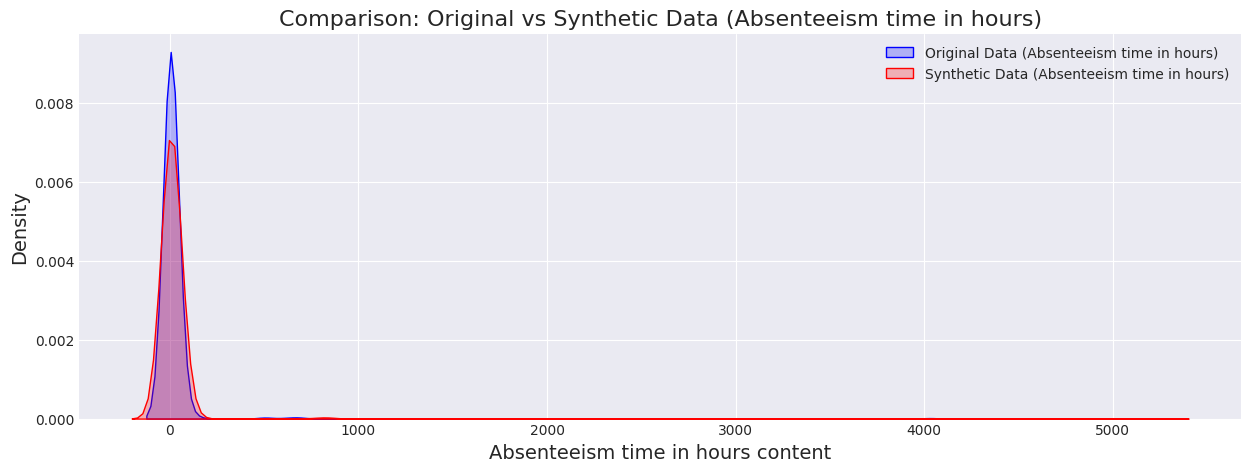


PIPELINE COMPLETADO


In [30]:
# =====================================================================
# EJECUCIÓN
# =====================================================================

if __name__ == "__main__":
    # Ejecutar pipeline con parámetros por defecto
    results = run_drift_detection_pipeline(
        #target_column='Absenteeism time in hours',
        mean_shift=0.3,
        test_size=0.3,
        random_state=42,
        p_val=0.05
    )